# Pre-processing notebook

In [2]:
!pip install pandas matplotlib scikit-learn deep_translator numpy tqdm

# Library imports
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt    

data_path = '/bin/data'
embeddings_path = '../bin/word_embeddings'
model_save_path = '../bin/models'


data_path = '/vol/bitbucket/az620/nlp-cw-2024' + data_path

## 1. Load Data

In [3]:
# Import Training Data

train_data_path = f'{data_path}/dontpatronizeme_pcl.tsv'

# Load into a panda's dataframe
train_data = pd.read_csv(train_data_path, delimiter='\t', skiprows=4, header=None, names=['par_id','art_id','keyword','country_code', 'text','label'])

# Drop redundant art_id column (irrelevant for binary classification task)
train_data = train_data.drop(['art_id'], axis=1)
train_data

,par_id,keyword,country_code,text,label
0,1,hopeless,ph,"We 're living in times of absolute insanity , ...",0
1,2,migrant,gh,"In Libya today , there are countless number of...",0
2,3,immigrant,ie,White House press secretary Sean Spicer said t...,0
3,4,disabled,nz,Council customers only signs would be displaye...,0
4,5,refugee,ca,""" Just like we received migrants fleeing El Sa...",0
...,...,...,...,...,...
10464,10465,women,lk,Sri Lankan norms and culture inhibit women fro...,1
10465,10466,vulnerable,ph,He added that the AFP will continue to bank on...,0
10466,10467,in-need,ng,""" She has one huge platform , and information ...",3
10467,10468,hopeless,in,""" Anja Ringgren Loven I ca n't find a word to ...",4


In [4]:
# Rename label column to PCL_score
train_data = train_data.rename(columns={'label': 'PCL_score'})

# Add Binary Classification column for binary task
train_data.loc[:, 'labels'] = 0
train_data.loc[train_data['PCL_score'].isin([2,3,4]), 'labels'] = 1

# Drop null values
train_data = train_data.dropna(subset = 'text')
train_data

,par_id,keyword,country_code,text,PCL_score,labels
0,1,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,immigrant,ie,White House press secretary Sean Spicer said t...,0,0
3,4,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,refugee,ca,""" Just like we received migrants fleeing El Sa...",0,0
...,...,...,...,...,...,...
10464,10465,women,lk,Sri Lankan norms and culture inhibit women fro...,1,0
10465,10466,vulnerable,ph,He added that the AFP will continue to bank on...,0,0
10466,10467,in-need,ng,""" She has one huge platform , and information ...",3,1
10467,10468,hopeless,in,""" Anja Ringgren Loven I ca n't find a word to ...",4,1


## 2. Generate (Train | Validation) Split

In [5]:
def generate_data_splits(train_data):
    # The stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify. 

    X_train, X_val, y_train, y_val = train_test_split(train_data[['text', 'keyword', 'country_code']]
                                                    , train_data['labels']
                                                    , train_size=0.8
                                                    , test_size=0.2
                                                    , random_state=0
                                                    , stratify=train_data[['labels']]
                                                    )
   
    return X_train, X_val, y_train, y_val


def pie_data_distributions(pie_series, pie_series_label):
    """Plots some pie charts for data distribution (Assume len(pie_series) inputs)

    Args:
        pie_series (_type_): pandas series 
        pie_series_label (_type_): for the title
    """

    assert len(pie_series) == len(pie_series_label) and "expected inputs of same length"

    _, axs = plt.subplots(1, len(pie_series), figsize=(len(pie_series)*5, 5))

    for idx, (series, title) in enumerate(zip(pie_series, pie_series_label)):
        tmp = series.value_counts()

        wedges, _, _ = axs[idx].pie(tmp, labels=tmp.index, autopct='%1.1f%%', startangle=90)
        legend_labels = [f'{label} ({count})' for label, count in zip(tmp.index, tmp)]
        axs[idx].legend(wedges, legend_labels, title="Class 1 and 0", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
        axs[idx].set_title(f'Distribution for {title}')

    plt.tight_layout()
    plt.show()

def print_train_val_statistics(train_data, val_data):
    print("=== DISTRIBUTION FOR TRAINING DATA ===")
    pie_data_distributions(
        [train_data['country_code'], train_data['keyword'], train_data['labels']],
        ['train country_code label', 'train keyword label', 'train binary classification']
    )

    print("=== DISTRIBUTION FOR VALIDATION DATA ===")
    pie_data_distributions(
        [val_data['country_code'], val_data['keyword'], val_data['labels']],
        ['validation country_code label', 'validation keyword label', 'validation binary classification']
    )

In [6]:
X_train, X_val, y_train, y_val = generate_data_splits(train_data)

=== DISTRIBUTION FOR TRAINING DATA ===


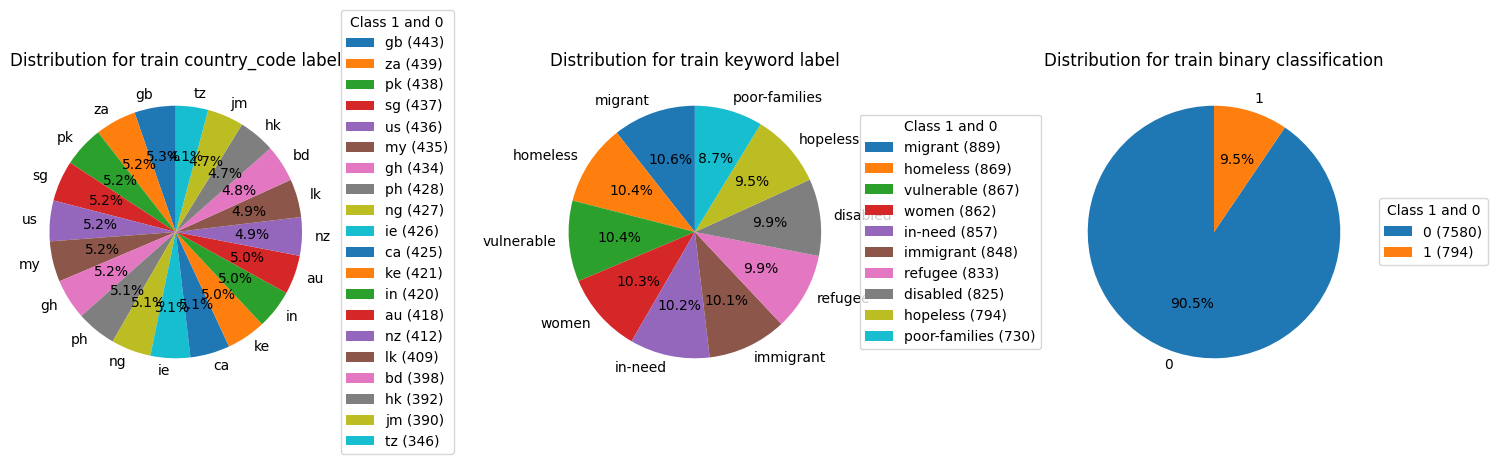

=== DISTRIBUTION FOR VALIDATION DATA ===


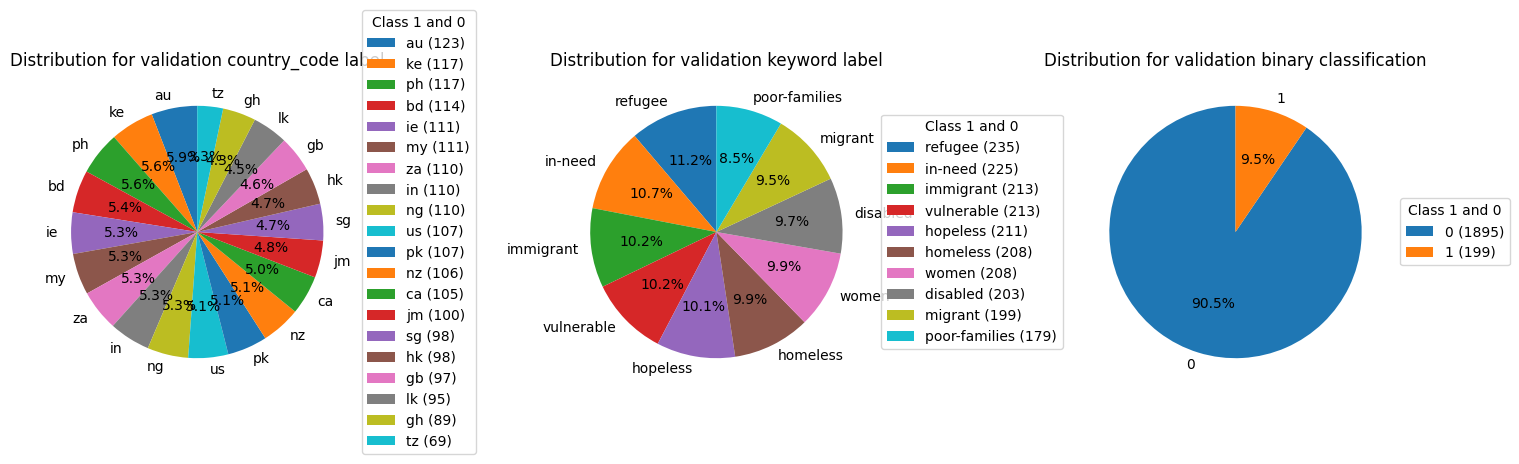

In [7]:
# combine the training and validation data into one pandas dataframe

sampled_train_data = pd.concat([X_train, y_train], axis=1)
sampled_val_data = pd.concat([X_val, y_val], axis=1)

print_train_val_statistics(sampled_train_data, sampled_val_data)

## 3. Augment the Training Data

In [8]:
from deep_translator import GoogleTranslator
import numpy as np

def multi_translate(text, depth=3):
    """Translate the given text through multiple languages.

    Args:
        text (str): The text to be translated.
        depth (int, optional): The number of languages to translate through. Defaults to 3.

    Returns:
        str: The translated text.
    """
    random_languages = np.random.choice(list(GoogleTranslator().get_supported_languages()), depth-1, replace=False)

    curr_language = 'english'

    for language in random_languages:
        text = GoogleTranslator(source=curr_language, target=language).translate(text)
        curr_language = language

    return GoogleTranslator(source=curr_language, target='english').translate(text)

In [9]:
multi_translate('This is a random sentence with lots of weaving context. I may not be always talking about the same thing. But one thing I\'m certain of is that I think I\'m better than minorities! This way, I am being condesending and harmful. But I don\'t care because I posted it online anonymously!', 2)

"It's a random sentence with a lot of knitting context. I may not always be talking about the same thing. But one thing I am sure of is that I think I am better than the minorities! In this way, I am mild and harmful. But I don't care because I posted it online anonymously!"

In [36]:
multi_translate("This sentence purpousfulleay contains a spelling mistake", 2)

'This sentence purpousfulleay contains a spelling error'

In [10]:
def random_sentence_reordering(text):
    """Randomly reorder the words in the input text

    Args:
        text (str): input text

    Returns:
        str: reordered text
    """    
    text = text.split('.')
    np.random.shuffle(text)
    return '.'.join(text)

In [11]:
random_sentence_reordering("Sentence 1 is in the first position. It may contain some important information for sentence 2, but yet, it may not. This is the beauty of data pre-processing. Sometimes, it doesn't make sense, but it doesn't always have to.")

" This is the beauty of data pre-processing.. Sometimes, it doesn't make sense, but it doesn't always have to.Sentence 1 is in the first position. It may contain some important information for sentence 2, but yet, it may not"

In [12]:
time_to_translate = 4 # seconds
time_to_reorder = 0 # seconds

len(sampled_train_data[sampled_train_data['labels'] == 1]) * (time_to_translate + time_to_reorder) / 60 / 60

0.8822222222222221

In [13]:
from tqdm import tqdm

augmented_train_data = pd.DataFrame(columns=sampled_train_data.columns)

for i, sentence in tqdm(sampled_train_data[sampled_train_data['labels'] == 1].iterrows()):
    # print(f'{len(augmented_train_data)}/{len(sampled_train_data[sampled_train_data["labels"] == 1])}')
    try:
        text = random_sentence_reordering(sentence['text'])
        text = multi_translate(text, 3)
    
        augmented_train_data = pd.concat([augmented_train_data, pd.DataFrame({'text': [text], 'keyword': [sentence['keyword']], 'country_code': [sentence['country_code']], 'labels': [sentence['labels']]})], ignore_index=True)
    except:
        pass

794it [1:07:32,  5.10s/it]


In [26]:
augmented_train_data.iloc[0]['text']

'How do you feel about life? Working hard. Sports game. Persistence. Loyalty: A. They take inner-city kids from poor families and teach them the values \u200b\u200bof golf.'

In [25]:
selected_data = sampled_train_data[(sampled_train_data['keyword'] == 'poor-families') & (sampled_train_data['country_code'] == 'za') & (sampled_train_data['labels'] == 1)]
selected_data.iloc[0]['text']
# sampled_train_data.iloc[6040]

'A : They are taking inner-city kids of poor families and teaching them values through golf . Persistence . Honesty . Hard work . Sportsmanship . How you deal with life .'

In [31]:
print(len(sampled_train_data[sampled_train_data['labels'] == 1]), len(augmented_train_data))

combined_train_data = pd.concat([sampled_train_data, augmented_train_data], ignore_index=True)

794 792


## 4. Save the Training Splits

=== DISTRIBUTION FOR TRAINING DATA ===


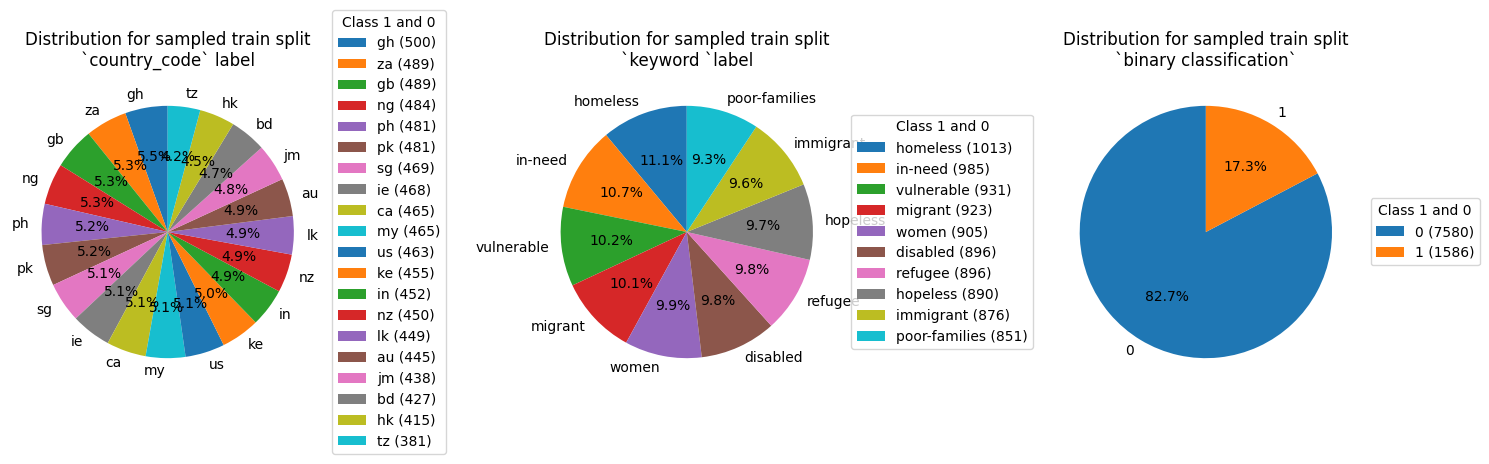

=== DISTRIBUTION FOR VALIDATION DATA ===


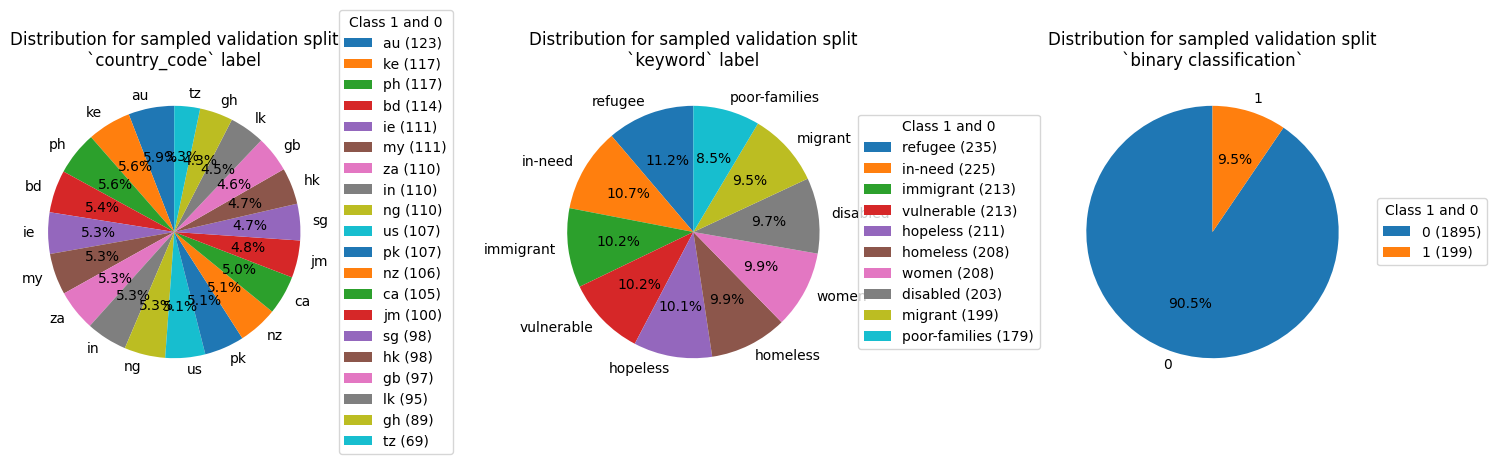

In [32]:
print("=== DISTRIBUTION FOR TRAINING DATA ===")
pie_data_distributions(
    [combined_train_data['country_code'], combined_train_data['keyword'], combined_train_data['labels']],
    ['sampled train split\n`country_code` label', 'sampled train split\n`keyword `label', 'sampled train split\n`binary classification`']
)

print("=== DISTRIBUTION FOR VALIDATION DATA ===")
pie_data_distributions(
    [sampled_val_data['country_code'], sampled_val_data['keyword'], sampled_val_data['labels']],
    ['sampled validation split\n`country_code` label', 'sampled validation split\n`keyword` label', 'sampled validation split\n`binary classification`']
)

In [33]:
# Save the sampled_train_data and sampled_val_data variables to tsv file

combined_train_data.to_csv(f'{data_path}/pre-processed/sampled_train_data.tsv', sep='\t', index=False)
sampled_val_data.to_csv(f'{data_path}/pre-processed/sampled_val_data.tsv', sep='\t', index=False)